## 4.3 개선판 word2vec 학습
PTB 데이터셋을 사용해 학습하고 단어의 분산 표현을 얻어보자

### 4.3.1 CBOW 모델 구현
앞장의 SimpleCBOW 클래스를 Embedding 계층과 Negative sampling Loss 계층을 적용한다.

In [1]:
import sys
sys.path.append('.')
from common.layers import Embedding, SigmoidWithLoss
import collections
from common.np import *  # import numpy as np

In [2]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [3]:
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample


In [4]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

In [14]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

### 4.3.2 CBOW 모델 학습

코드는 "4장_train.ipynb"에 있다 train을 돌리고 나면 pkl파일이 생성된다.
Cupy 버젼이 8.0.0 버젼 밑으로는 지원하지 않아서 9.2.0버전으로 학습시켰는데
애먹었다.

error 1 : TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly. (아직 해결 못함 뭐가 문제지..?)
error 2 : scatter_add 문제 이거는 8버전 밑으로는 지원했지만 8버전 위로는 없는 모듈이 되어버렸다.
정확히는 cupyx에 있는 모듈로 import해주면 간단하게 해결된다!

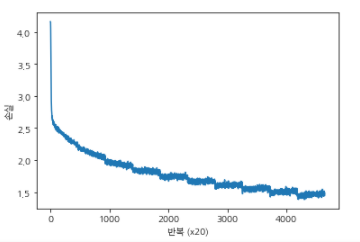

### 4.3.3 CBOW 모델 평가

학습된 pkl파일로 평가를 해보자
결과는 각각 같은 성격을 가진 단어들이 나왔다.
toyota는 비슷한 자동차 메이커가 나왔다.

In [17]:
from common.util import most_similar, analogy
import pickle


pkl_file = 'ch04/cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.74609375
 i: 0.6982421875
 your: 0.62548828125
 they: 0.61474609375
 anything: 0.57373046875

[query] year
 month: 0.85009765625
 week: 0.7958984375
 summer: 0.7724609375
 spring: 0.73828125
 decade: 0.685546875

[query] car
 truck: 0.6240234375
 window: 0.62255859375
 luxury: 0.6044921875
 auto: 0.57666015625
 cars: 0.5703125

[query] toyota
 engines: 0.64111328125
 honda: 0.634765625
 beretta: 0.62109375
 seita: 0.62109375
 mazda: 0.60107421875


king:man = queen:? 의 답은 "woman"인데 2등에 자리고 있고 a.m이 1등이다 왜그러지..?

take:took = go:? 의 답은 "went"이다 순위에는 있는데 5등이라는 처참한 등수이다.

car:cars = child:? 의 답은 "children" 3등

good:better = bad:? 의 답은 "worse" 순위 밖

In [16]:
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

--------------------------------------------------

[analogy] king:man = queen:?
 a.m: 5.45703125
 woman: 5.22265625
 toxin: 4.8984375
 yard: 4.859375
 gene: 4.80078125

[analogy] take:took = go:?
 eurodollars: 4.9140625
 were: 4.7265625
 're: 4.55078125
 came: 4.3515625
 went: 4.28125

[analogy] car:cars = child:?
 a.m: 6.828125
 daffynition: 5.66015625
 children: 5.40625
 rape: 4.9921875
 adults: 4.96875

[analogy] good:better = bad:?
 rather: 5.76171875
 less: 5.453125
 more: 5.359375
 greater: 4.40234375
 faster: 3.615234375
